# This is an exmaple of how DenseNet is build by Tensorflow 2

DenseNet的网络结构如下所示:
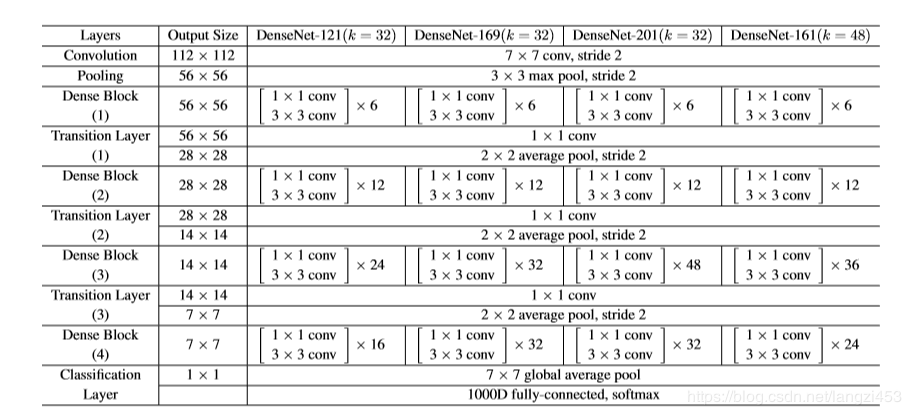

DenseNet的核心模块DenseBlock的结构如下所示:
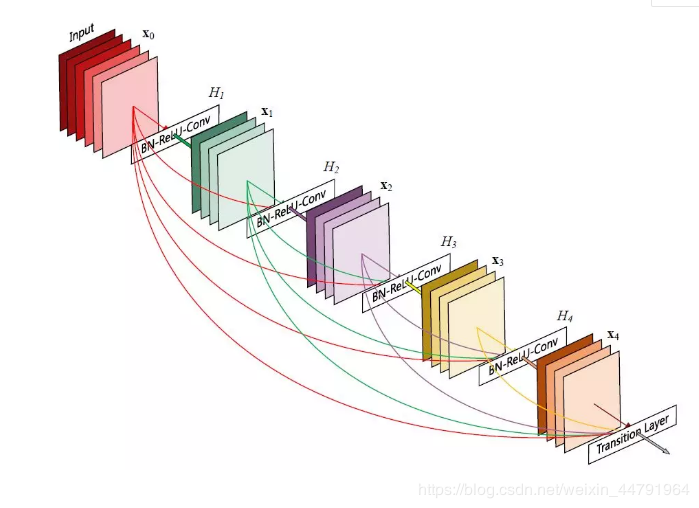

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Model

print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


In [20]:
class DenseBlock(layers.Layer):
    def __init__(self, blocks, growth_rate = 32, **kwargs):
        super().__init__(**kwargs)
        self.blocks = blocks
        self.growth_rate = growth_rate

    def build(self, input_shape):
        self.layer_bn_a, self.layer_bn_b = [], []
        self.layer_conv2D_a, self.layer_conv2D_b = [], []
        self.layer_relu = layers.Activation('relu')
        self.layer_concat = layers.Concatenate(axis = -1)
        for i in range(self.blocks):
            self.layer_bn_a.append(layers.BatchNormalization(epsilon=1.001e-5))
            self.layer_bn_b.append(layers.BatchNormalization(epsilon=1.001e-5))
            self.layer_conv2D_a.append(layers.Conv2D(4 * self.growth_rate, 1, padding='same', use_bias=False))
            self.layer_conv2D_b.append(layers.Conv2D(self.growth_rate, 3, padding='same', use_bias=False))
        super().build(input_shape)
        
    def call(self, inputs, training=True, **kwargs):
        x = inputs
        for i in range(self.blocks):
            x1 = self.layer_bn_a[i](x, training=training)
            x1 = self.layer_relu(x1)
            x1 = self.layer_conv2D_a[i](x1, training=training)
            x1 = self.layer_bn_b[i](x1, training=training)
            x1 = self.layer_relu(x1)
            x1 = self.layer_conv2D_b[i](x1, training=training)
            x = self.layer_concat([x, x1])
        return x
    

class TransitionBlock(layers.Layer):
    def __init__(self, reduction = 0.5, **kwargs):
        super().__init__(**kwargs)
        self.reduction = reduction
        
    def build(self, input_shape):
        self.layer_bn = layers.BatchNormalization(epsilon=1.001e-5)
        self.layer_relu = layers.Activation('relu')
        self.layer_conv2D = layers.Conv2D(int(input_shape[-1] * self.reduction), 1, padding='same', use_bias=False)
        self.layer_ap = layers.AveragePooling2D(2, strides=2)
        super().build(input_shape)  
    
    def call(self, inputs, training=None, **kwargs):
        x = self.layer_bn(inputs, training=training)
        x = self.layer_relu(x)
        x = self.layer_conv2D(x, training=training)
        x = self.layer_ap(x)
        return x

In [21]:
def DenseNet(blocks, input_shape=None, classes=1000, name = '', **kwargs):
    inputs = layers.Input(shape=input_shape)
    bn_axis = 3

    # 224,224,3 -> 112,112,64
    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(inputs)
    x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='Conv1/Conv')(x)
    x = layers.BatchNormalization(epsilon=1.001e-5, name='Conv1/Bn')(x)
    x = layers.Activation('relu', name='Conv1/Relu')(x)
    
    # 112,112,64 -> 56,56,64
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = layers.MaxPooling2D(3, strides=2, name='Pool1')(x)


    for i in range(len(blocks)):
        x = DenseBlock(blocks[i], name='DenseBlock' + str(i))(x)
        if i != len(blocks) - 1: # Skip Last TransitionBlock
            x = TransitionBlock(0.5, name='TransitionBlock' + str(i))(x)
            
    x = layers.BatchNormalization(epsilon=1.001e-5, name='Bn')(x)
    x = layers.Activation('relu', name='Relu')(x)

    x = layers.GlobalAveragePooling2D(name='Ap')(x)
    x = layers.Dense(classes, activation='softmax', name='Fc1000')(x)

    return Model(inputs, x, name=name)

In [23]:
def DenseNet121(input_shape=[224,224,3], classes=1000, name = 'densenet121', **kwargs):
    return DenseNet([6, 12, 24, 16], input_shape, classes, name, **kwargs)

model = DenseNet121()
model.summary()

Model: "densenet121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 230, 230, 3)       0         
_________________________________________________________________
Conv1/Conv (Conv2D)          (None, 112, 112, 64)      9408      
_________________________________________________________________
Conv1/Bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
Conv1/Relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 56, 56, 64)        

Total params: 8,062,504
Trainable params: 7,978,856
Non-trainable params: 83,648